## Importing the essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Importing the dataset over here

In [2]:
data=pd.read_csv("Domestic violence.csv")

In [3]:
data.head()

,SL. No,Age,Education,Employment,Income,Marital status,Violence
0,1,30,secondary,unemployed,0,married,yes
1,2,47,tertiary,unemployed,0,married,no
2,3,24,tertiary,unemployed,0,unmarred,no
3,4,22,tertiary,unemployed,0,unmarred,no
4,5,50,primary,unemployed,0,married,yes


In [4]:
data.columns

Index(['SL. No', 'Age', 'Education ', 'Employment ', 'Income',
       'Marital status ', 'Violence '],
      dtype='object')

## Taking care of missing values if present inside the dataset or not

In [5]:
data.isnull().sum()

,0
SL. No,0
Age,0
Education,0
Employment,0
Income,0
Marital status,0
Violence,0


## Taking care of duplicate observations if present over here or not

In [6]:
data.duplicated().sum()

0

## Taking care of dataset whether it is imbalanced or not over here

In [7]:
data['Violence '].value_counts()

,count
Violence,
no,261
yes,86


## Observations
This dataset is imbalanced we need to handle it properly over here

## Fitlering all the numerical features over here

In [8]:
numerical_features=[feature for feature in data.columns if data[feature].dtype!="O"]
for feature in numerical_features:
  print(feature)

SL. No
Age
Income


In [9]:
data[numerical_features]

,SL. No,Age,Income
0,1,30,0
1,2,47,0
2,3,24,0
3,4,22,0
4,5,50,0
...,...,...,...
342,343,27,30000
343,344,26,35000
344,345,27,0
345,346,29,0


## Filteirng all the categorical features over here

In [10]:
cat_features=[feature for feature in data.columns if data[feature].dtype=="O"]
for feature in cat_features:
  print(feature)

Education 
Employment 
Marital status 
Violence 


In [11]:
data[cat_features]

,Education,Employment,Marital status,Violence
0,secondary,unemployed,married,yes
1,tertiary,unemployed,married,no
2,tertiary,unemployed,unmarred,no
3,tertiary,unemployed,unmarred,no
4,primary,unemployed,married,yes
...,...,...,...,...
342,tertiary,semi employed,unmarred,no
343,tertiary,employed,married,no
344,primary,unemployed,married,yes
345,primary,unemployed,married,no


## Encoding the categorical features into numerical features over here

In [12]:
for feature in cat_features:
  feature_mapping={category:index for index,category in enumerate(data[feature].unique())}
  data[feature]=data[feature].map(feature_mapping)

In [13]:
data

,SL. No,Age,Education,Employment,Income,Marital status,Violence
0,1,30,0,0,0,0,0
1,2,47,1,0,0,0,1
2,3,24,1,0,0,1,1
3,4,22,1,0,0,1,1
4,5,50,2,0,0,0,0
...,...,...,...,...,...,...,...
342,343,27,1,1,30000,1,1
343,344,26,1,2,35000,0,1
344,345,27,2,0,0,0,0
345,346,29,2,0,0,0,1


In [14]:
data.columns

Index(['SL. No', 'Age', 'Education ', 'Employment ', 'Income',
       'Marital status ', 'Violence '],
      dtype='object')

## Calculating the Informatino Value (IV) to determine the predictive power of the feature over here

In [15]:
def calculate_woe_iv(data, feature, target):
    df = pd.DataFrame({
        'feature': data[feature],
        'target': data[target]
    })

    df['bin'] = pd.qcut(df['feature'], q=10, duplicates='drop')

    total_events = df['target'].sum()
    total_non_events = df['target'].count() - total_events

    grouped = df.groupby('bin').agg({
        'target': ['sum', 'count']
    })

    grouped.columns = ['events', 'total']
    grouped['non_events'] = grouped['total'] - grouped['events']

    grouped = grouped[(grouped['events'] > 0) & (grouped['non_events'] > 0)]

    grouped['event_rate'] = grouped['events'] / total_events
    grouped['non_event_rate'] = grouped['non_events'] / total_non_events
    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])

    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    iv = grouped['iv'].sum()

    return grouped[['woe', 'iv']], iv

def calculate_iv(data, target):
    iv_dict = {}
    for feature in data.columns:
        if feature != target:
            _, iv = calculate_woe_iv(data, feature, target)
            iv_dict[feature] = iv
    return iv_dict

<ipython-input-15-d734d1651417>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg({
<ipython-input-15-d734d1651417>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg({
<ipython-input-15-d734d1651417>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').agg({
<ipython-input-15-d734d1651417>:12: FutureWarning: The default of observed=F

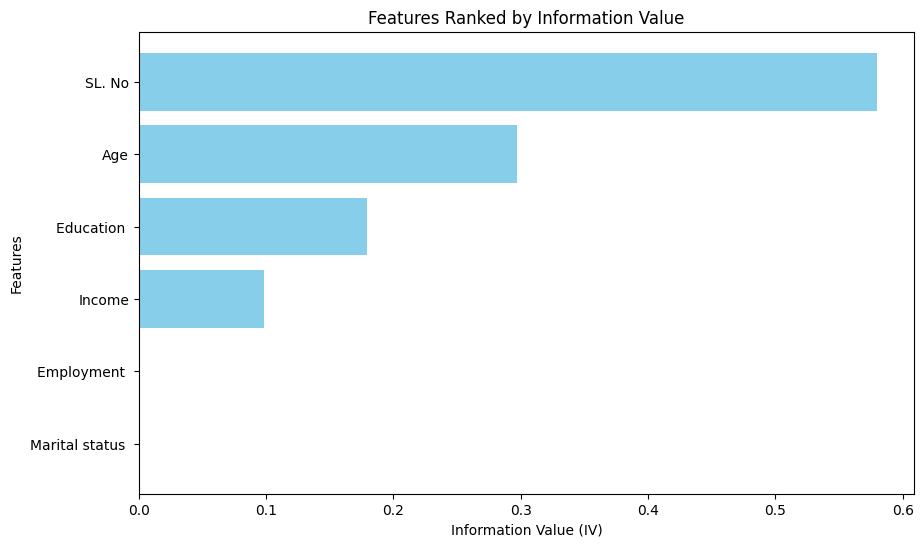

Feature: SL. No, IV: 0.5799
Feature: Age, IV: 0.2968
Feature: Education , IV: 0.1796
Feature: Income, IV: 0.0980
Feature: Employment , IV: 0.0007
Feature: Marital status , IV: 0.0000


In [16]:
iv_values = calculate_iv(data, 'Violence ')
sorted_iv = sorted(iv_values.items(), key=lambda x: x[1], reverse=True)

features = [x[0] for x in sorted_iv]
iv_scores = [x[1] for x in sorted_iv]

plt.figure(figsize=(10, 6))
plt.barh(features, iv_scores, color='skyblue')
plt.xlabel('Information Value (IV)')
plt.ylabel('Features')
plt.title('Features Ranked by Information Value')
plt.gca().invert_yaxis()
plt.show()

for feature, iv in sorted_iv:
    print(f"Feature: {feature}, IV: {iv:.4f}")

In [17]:
data.drop(['Marital status ','Employment '],axis=1,inplace=True)

## Creating the features and labels over here

In [18]:
X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

## Splitting the dataset into training set and testing set to avoid the problem of overfitting over here

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

## Training the model on the training dataset over here

In [20]:
class_weight = {0: 1.33, 1: 4.03}

In [21]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=100,criterion="entropy",random_state=0,class_weight=class_weight)
classifier.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1.33, 1: 4.03}, criterion='entropy',
                       random_state=0)

## Evaluating the performance of the model on the testing dataset over here

In [22]:
y_pred=classifier.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

[[1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 0]]


## Printing the Classification Report over here

In [23]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.29      0.44        24
           1       0.73      0.98      0.83        46

    accuracy                           0.74        70
   macro avg       0.80      0.63      0.64        70
weighted avg       0.78      0.74      0.70        70



In [24]:
accuracy_score(y_test,y_pred)

0.7428571428571429

## Evaluating the performance of the model based on the AUC (Area Under Curve) over here

AUC: 0.6757


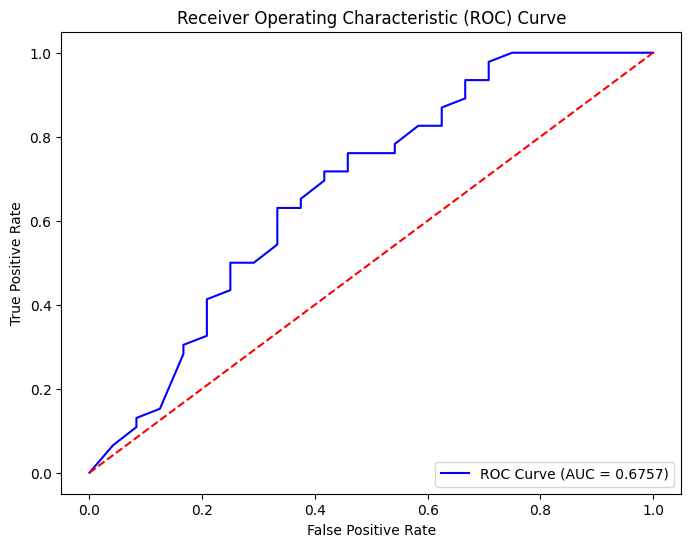

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = classifier.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line for a random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
